In [1]:
# 1. Setup
import os
import zipfile
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2


from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files
from PIL import Image



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
dataset_dir = path +"/train"
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images


In [2]:
# 2. Upload ZIP File
#uploaded = files.upload()
#for fname in uploaded.keys():
#    zip_path = fname

# Unzip
dataset_dir = '/content/drive/MyDrive/dataset'
#with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#    zip_ref.extractall(dataset_dir)

# List folders
os.listdir(dataset_dir)


['ai', 'real']

In [3]:
# 3. Transforms and DataLoader
transform = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Full dataset
full_dataset = datasets.ImageFolder(dataset_dir, transform=transform['train'])

# Split
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes
print(f"Classes: {class_names}")


Classes: ['ai', 'real']


In [ ]:
# 4. Load Pretrained ResNet50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 153MB/s]


In [ ]:
# 5. Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [ ]:
# 6. Train & Evaluate Functions
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()

    return running_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return (running_loss / len(loader.dataset),
            correct / len(loader.dataset),
            all_preds,
            all_labels)


In [ ]:
# 7. Training Loop
epochs = 6
for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc, preds, labels = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
Train Loss: 0.4928 | Train Acc: 0.7663
Val Loss:   0.4469 | Val Acc:   0.7889
Epoch 2/20
Train Loss: 0.4345 | Train Acc: 0.8004
Val Loss:   0.4232 | Val Acc:   0.7955
Epoch 3/20
Train Loss: 0.4188 | Train Acc: 0.8100
Val Loss:   0.4130 | Val Acc:   0.8126
Epoch 4/20
Train Loss: 0.3930 | Train Acc: 0.8215
Val Loss:   0.4318 | Val Acc:   0.8032
Epoch 5/20
Train Loss: 0.4133 | Train Acc: 0.8124
Val Loss:   0.4156 | Val Acc:   0.8026
Epoch 6/20
Train Loss: 0.4061 | Train Acc: 0.8190
Val Loss:   0.4959 | Val Acc:   0.7613
Epoch 7/20
Train Loss: 0.4179 | Train Acc: 0.8126
Val Loss:   0.4223 | Val Acc:   0.8104
Epoch 8/20
Train Loss: 0.4008 | Train Acc: 0.8185
Val Loss:   0.4230 | Val Acc:   0.8049
Epoch 9/20
Train Loss: 0.3772 | Train Acc: 0.8305
Val Loss:   0.3804 | Val Acc:   0.8275
Epoch 10/20
Train Loss: 0.3708 | Train Acc: 0.8393
Val Loss:   0.4008 | Val Acc:   0.8153
Epoch 11/20
Train Loss: 0.3872 | Train Acc: 0.8312
Val Loss:   0.3758 | Val Acc:   0.8297
Epoch 12/20
Train L


Classification Report:
              precision    recall  f1-score   support

          ai       0.78      0.60      0.68       529
        real       0.85      0.93      0.89      1285

    accuracy                           0.83      1814
   macro avg       0.81      0.76      0.78      1814
weighted avg       0.83      0.83      0.83      1814



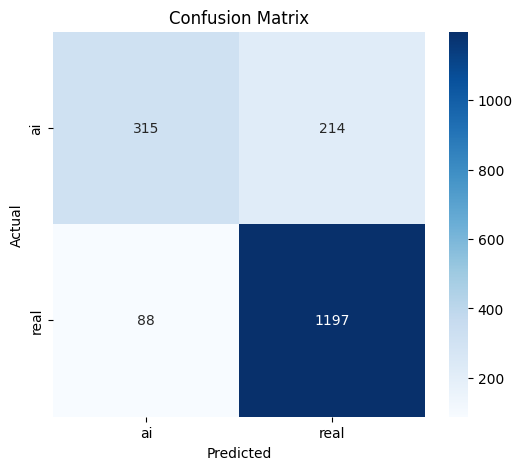

In [ ]:
# 8. Metrics Report
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=class_names))

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# 9. Save Model
torch.save(model.state_dict(), 'resnet50_ai_vs_real_v2.pt')
files.download('resnet50_ai_vs_real_v2.pt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [36]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 2)
model.load_state_dict(torch.load('/content/drive/MyDrive/resnet50_ai_vs_real_v2.pt', map_location=device))
model = model.to(device)
model.eval()

# Class names (same as training)
class_names = ['ai', 'real']

# Preprocessing (same as training val transform)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [37]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = class_names[predicted.item()]

    # Show the image with prediction
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

# 🔍 Example usage
#predict_image('/content/drive/MyDrive/testdata/ai/girl-8615258_1280.jpg')



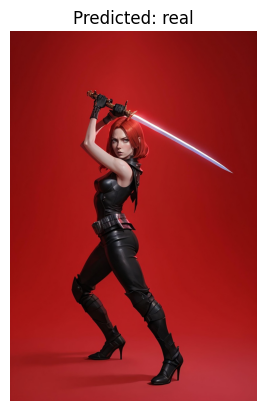

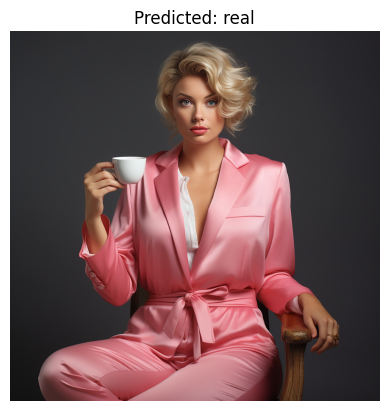

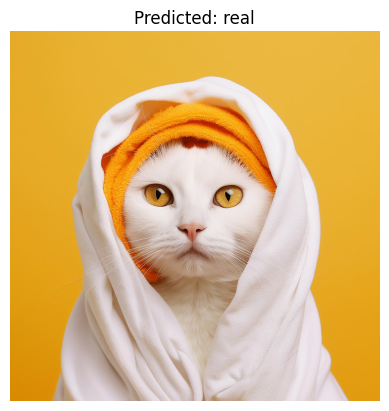

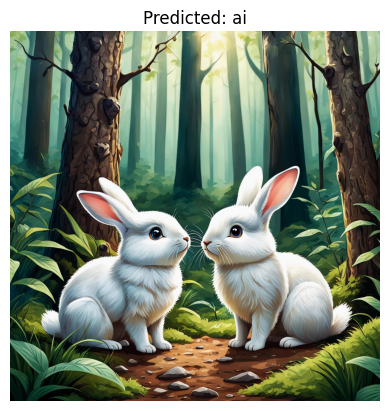

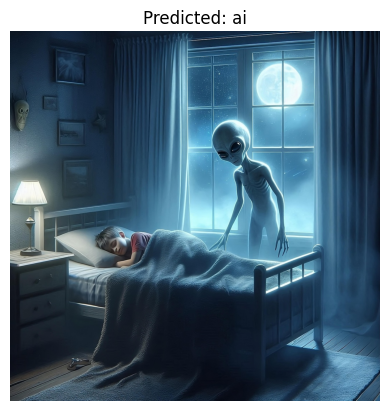

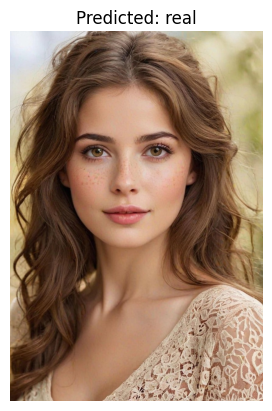

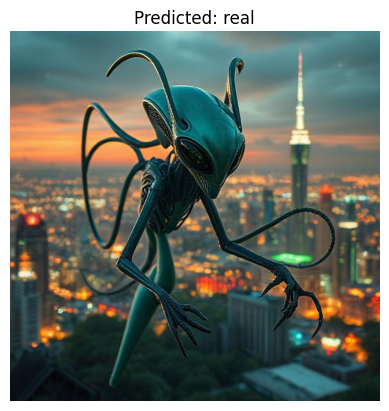

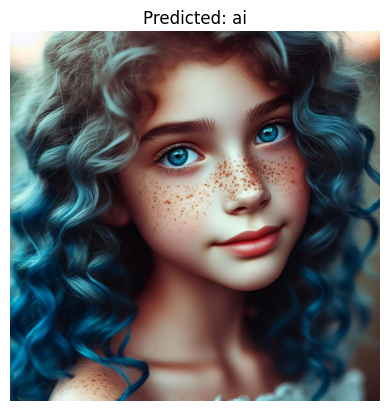

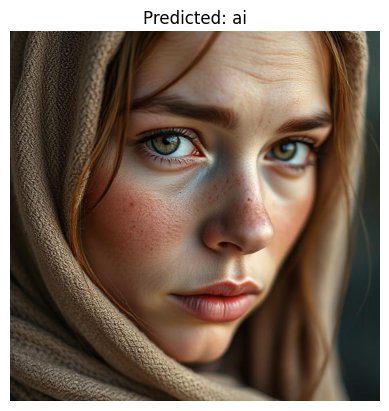

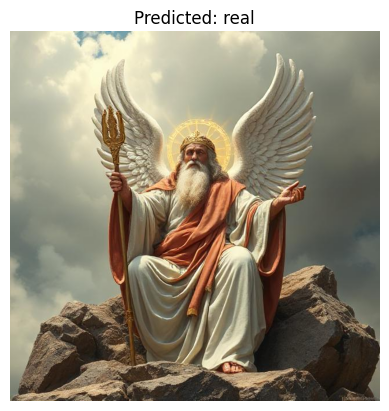

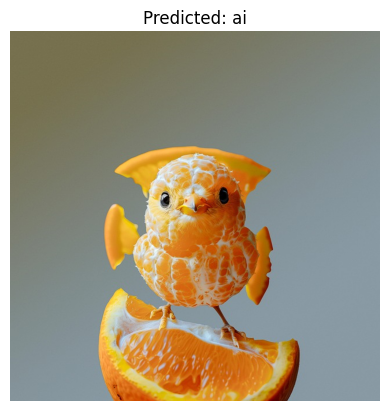

ai-generated-8698024_1280.jpg => real
ai-generated-8118606_1280.png => real
ai-generated-8359510_1280.jpg => real
ai-generated-8700793_1280.jpg => ai
ai-generated-8762641_1280.jpg => ai
girl-8615258_1280.jpg => real
1f76ac73-9a04-45b1-8a10-fb9edc028d7a.jpeg => real
ai-generated-8720322_640.jpg => ai
AI generated using prompts.jpeg => ai
9f408259-4d71-4f89-ae3d-edeef2722901.jpeg => real
ai-generated-8637800_640.jpg => ai


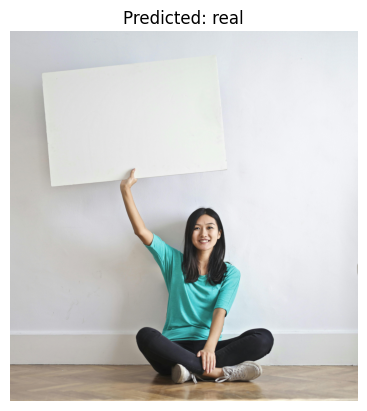

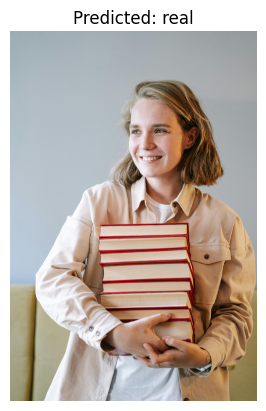

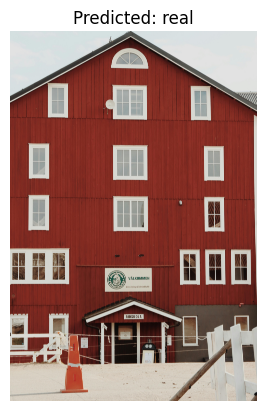

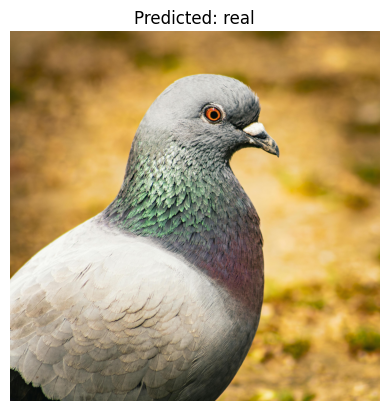

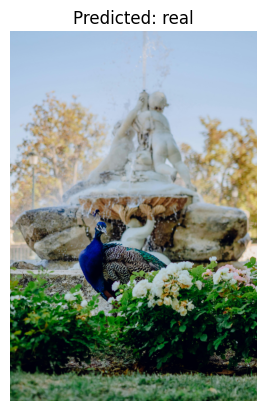

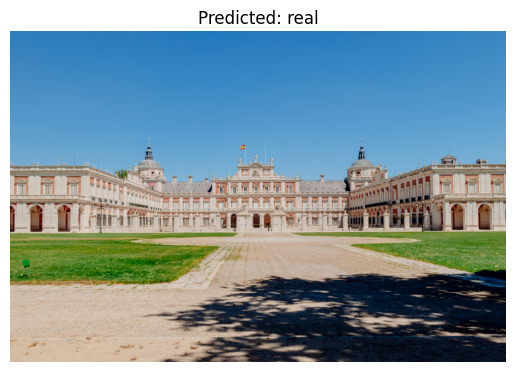

pexels-olly-3758104.jpg => real
pexels-ivan-samkov-5428770.jpg => real
pexels-efrem-efre-2786187-20595322.jpg => real
pexels-shotsimplephoto-31625143.jpg => real
pexels-kevin-leon-421907694-27781520.jpg => real
pexels-kevin-leon-421907694-27781510.jpg => real


In [38]:
import os

def predict_folder(folder_path):
    results = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder_path, filename)
            prediction = predict_image(path)
            results.append((filename, prediction))
    return results

# Example usage
folder_results = predict_folder('/content/drive/MyDrive/testdata/ai')
for fname, pred in folder_results:
    print(f'{fname} => {pred}')
folder_results2 = predict_folder('/content/drive/MyDrive/testdata/real')
for fname, pred in folder_results2:
    print(f'{fname} => {pred}')

In [5]:
gradients = []
activations = []

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def forward_hook(module, input, output):
    activations.append(output)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.mobilenet_v2(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
model.classifier[1] = nn.Linear(model.last_channel, 2)  # 2 classes
model = model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 103MB/s] 


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

def train(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct = 0.0, 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        correct += (outputs.argmax(1) == labels).sum().item()

    return running_loss / len(loader.dataset), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct = 0.0, 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            correct += (outputs.argmax(1) == labels).sum().item()

    return running_loss / len(loader.dataset), correct / len(loader.dataset)


In [8]:
epochs = 10

for epoch in range(epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
    print(f"Val Loss:   {val_loss:.4f} | Acc: {val_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/10
Train Loss: 0.4828 | Acc: 0.7718
Val Loss:   0.4543 | Acc: 0.7935
Epoch 2/10
Train Loss: 0.4624 | Acc: 0.7889
Val Loss:   0.4335 | Acc: 0.8023
Epoch 3/10
Train Loss: 0.4516 | Acc: 0.7902
Val Loss:   0.4934 | Acc: 0.7709
Epoch 4/10
Train Loss: 0.4470 | Acc: 0.7999
Val Loss:   0.4790 | Acc: 0.7858
Epoch 5/10
Train Loss: 0.4347 | Acc: 0.8054
Val Loss:   0.4327 | Acc: 0.7919
Epoch 6/10
Train Loss: 0.4362 | Acc: 0.7974
Val Loss:   0.4930 | Acc: 0.7726
Epoch 7/10
Train Loss: 0.4622 | Acc: 0.7940
Val Loss:   0.4184 | Acc: 0.7963
Epoch 8/10
Train Loss: 0.4505 | Acc: 0.7940
Val Loss:   0.4133 | Acc: 0.8051
Epoch 9/10
Train Loss: 0.4537 | Acc: 0.7926
Val Loss:   0.4180 | Acc: 0.7974
Epoch 10/10
Train Loss: 0.4311 | Acc: 0.8014
Val Loss:   0.4137 | Acc: 0.8012


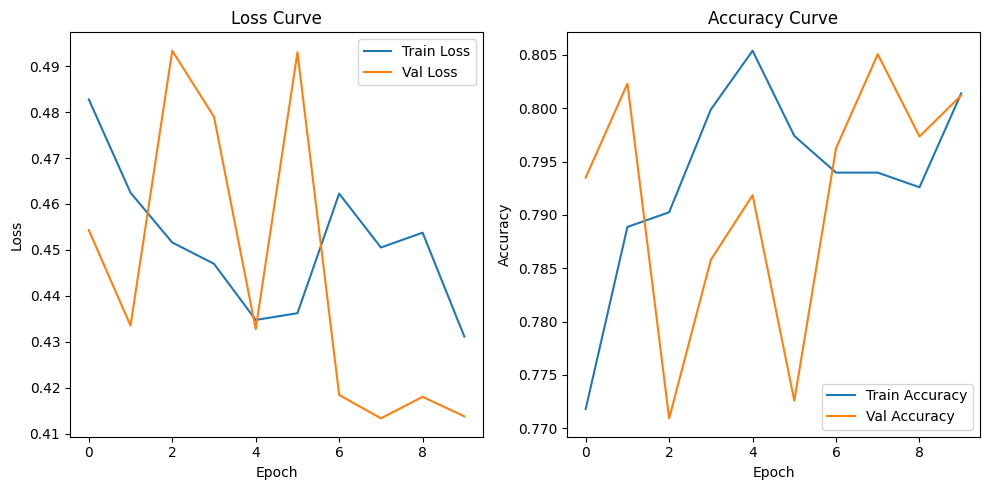

In [9]:
plt.figure(figsize=(10, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
torch.save(model.state_dict(), 'mobilenetv2_ai_vs_real.pt')
files.download('mobilenetv2_ai_vs_real.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
gradients = []
activations = []

def backward_hook(module, grad_input, grad_output):
    gradients.append(grad_output[0])

def forward_hook(module, input, output):
    activations.append(output)


In [31]:
def evaluate_classification_report(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Optional: show confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)


In [33]:
class_names = full_dataset.classes
evaluate_classification_report(model, val_loader, class_names)

Classification Report:
              precision    recall  f1-score   support

          ai       0.72      0.52      0.60       501
        real       0.83      0.92      0.88      1315

    accuracy                           0.81      1816
   macro avg       0.78      0.72      0.74      1816
weighted avg       0.80      0.81      0.80      1816

Confusion Matrix:
[[ 259  242]
 [ 102 1213]]


In [34]:
def evaluate_and_plot_confusion_matrix(model, dataloader, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification Report
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()


Classification Report:

              precision    recall  f1-score   support

          ai       0.73      0.53      0.61       501
        real       0.84      0.93      0.88      1315

    accuracy                           0.82      1816
   macro avg       0.78      0.73      0.75      1816
weighted avg       0.81      0.82      0.81      1816



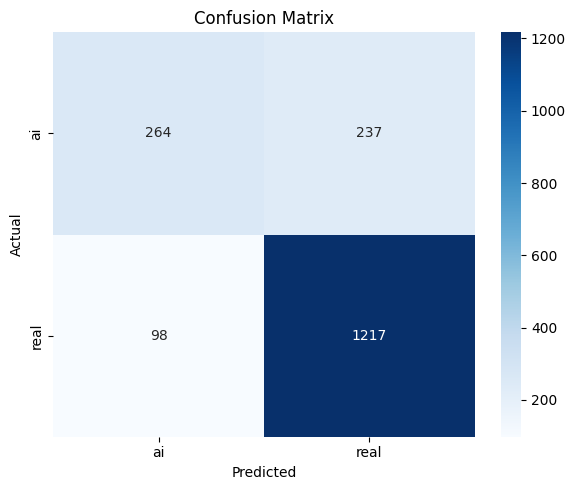

In [35]:
evaluate_and_plot_confusion_matrix(model, val_loader, class_names)

In [25]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.last_channel, 2)
model.load_state_dict(torch.load('/content/drive/MyDrive/mobilenetv2_ai_vs_real.pt', map_location=device))
model = model.to(device)
model.eval()

# Class names (same as training)
class_names = ['ai', 'real']

# Preprocessing (same as training val transform)
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])


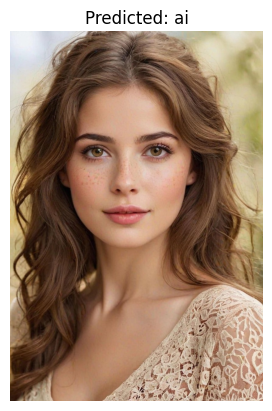

'ai'

In [26]:
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')
    input_tensor = preprocess(image).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)

    predicted_class = class_names[predicted.item()]

    # Show the image with prediction
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_class}')
    plt.axis('off')
    plt.show()

    return predicted_class

# 🔍 Example usage
predict_image('/content/drive/MyDrive/testdata/ai/girl-8615258_1280.jpg')



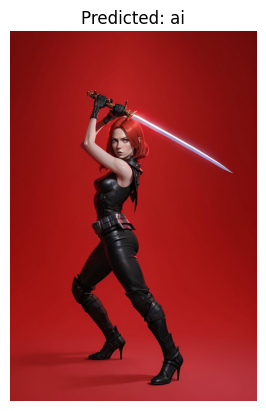

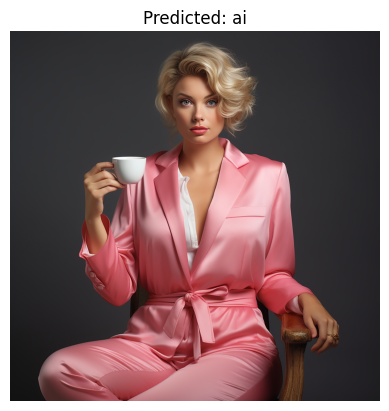

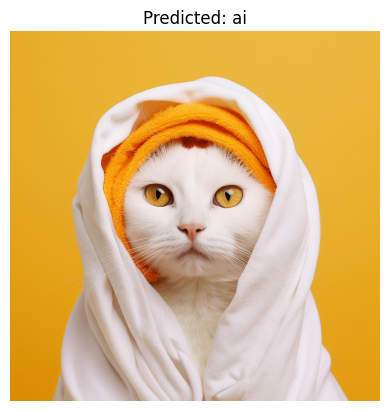

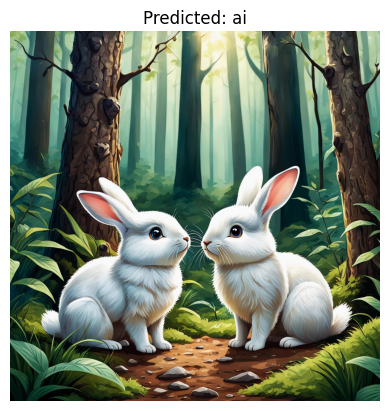

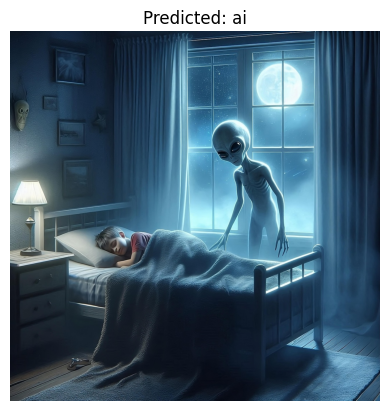

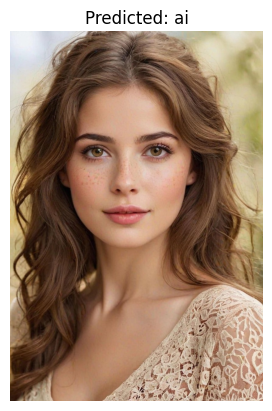

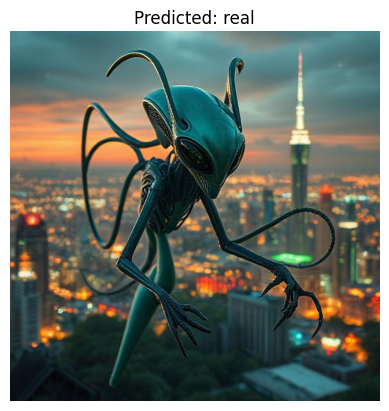

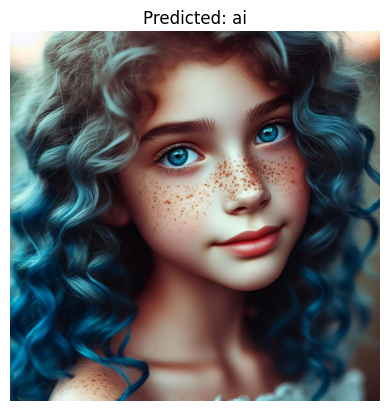

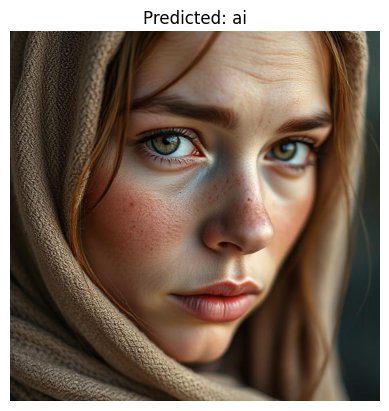

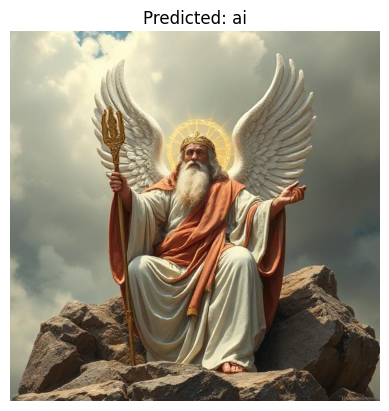

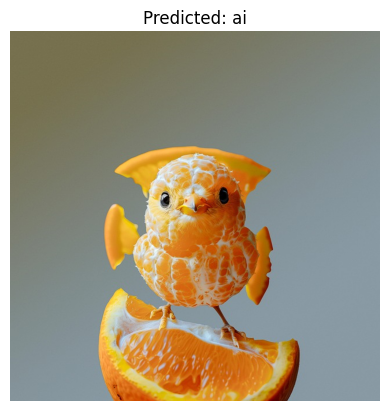

ai-generated-8698024_1280.jpg => ai
ai-generated-8118606_1280.png => ai
ai-generated-8359510_1280.jpg => ai
ai-generated-8700793_1280.jpg => ai
ai-generated-8762641_1280.jpg => ai
girl-8615258_1280.jpg => ai
1f76ac73-9a04-45b1-8a10-fb9edc028d7a.jpeg => real
ai-generated-8720322_640.jpg => ai
AI generated using prompts.jpeg => ai
9f408259-4d71-4f89-ae3d-edeef2722901.jpeg => ai
ai-generated-8637800_640.jpg => ai


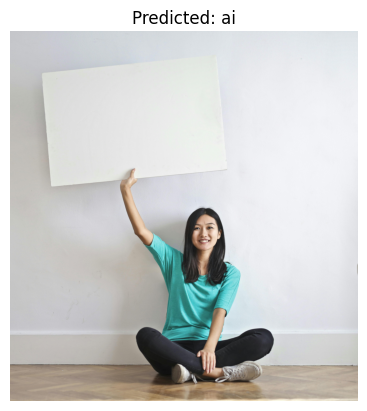

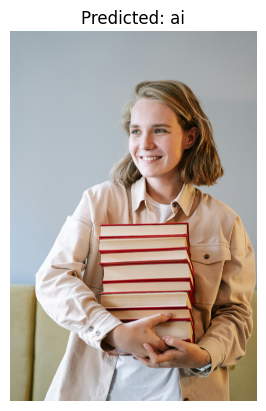

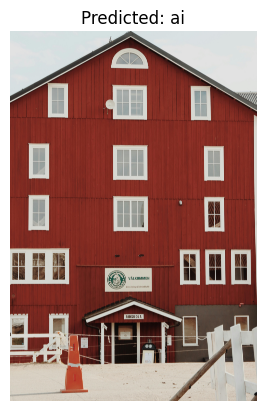

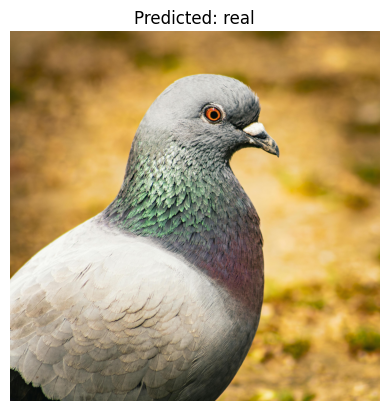

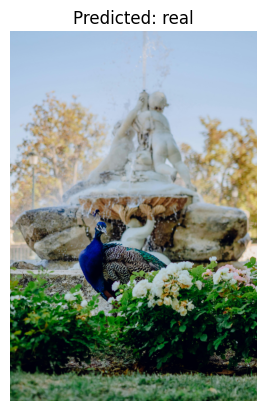

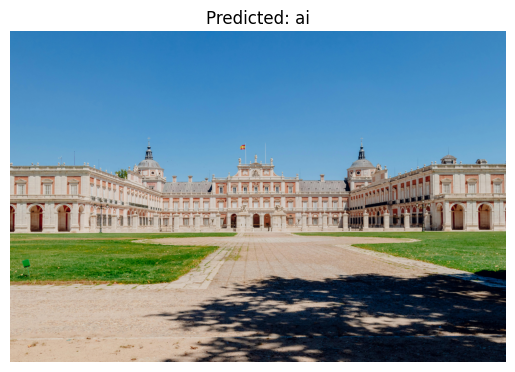

pexels-olly-3758104.jpg => ai
pexels-ivan-samkov-5428770.jpg => ai
pexels-efrem-efre-2786187-20595322.jpg => ai
pexels-shotsimplephoto-31625143.jpg => real
pexels-kevin-leon-421907694-27781520.jpg => real
pexels-kevin-leon-421907694-27781510.jpg => ai


In [29]:
import os

def predict_folder(folder_path):
    results = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            path = os.path.join(folder_path, filename)
            prediction = predict_image(path)
            results.append((filename, prediction))
    return results

# Example usage
folder_results = predict_folder('/content/drive/MyDrive/testdata/ai')
for fname, pred in folder_results:
    print(f'{fname} => {pred}')
folder_results2 = predict_folder('/content/drive/MyDrive/testdata/real')
for fname, pred in folder_results2:
    print(f'{fname} => {pred}')